In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
# Load pickle file of preprocessed dataset

pickle_file = 'SVHN_multi_2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # Hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Testing set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Testing set (13068, 32, 32, 1) (13068, 6)


In [13]:
# Split dataset for sensitivity analysis
# 90%
dataset_90pct = train_dataset[:208000,:,:,:]
labels_90pct = train_labels[:208000,:]

# 80%
dataset_80pct = train_dataset[:186000,:,:,:]
labels_80pct = train_labels[:186000,:]

# 70%
dataset_70pct = train_dataset[:162000,:,:,:]
labels_70pct = train_labels[:162000,:]

In [3]:
def accuracy(predictions, labels):
        return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) 
                / predictions.shape[1] / predictions.shape[0])

from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
% matplotlib inline
def conf_mat(y_true, y_pred):
    cm = ConfusionMatrix(y_true, y_pred)
    cm.plot(normalized=True)
    plt.show
    print(cm)

In [4]:
# Convolutional Neural Network Architecture

img_size = 32
num_channels = 1
num_labels = 11 # 0 - 9, + blank digits
seq_length = 6

batch_size = 128


# Add variable summaries for TensorBoard
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.scalar_summary('sttdev/' + name, stddev)
    tf.scalar_summary('max/' + name, tf.reduce_max(var))
    tf.scalar_summary('min/' + name, tf.reduce_min(var))
    tf.histogram_summary(name, var)

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, img_size, img_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, seq_length))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Helper functions for convolution and pooling
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], 
                              strides=[1, 2, 2, 1], padding='SAME')
        
    def avg_pool_2x2(x):
        return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], 
                              strides=[1, 2, 2, 1], padding='SAME')
    
    def mixed_max_avg_pool_2x2(x, alpha):
        return (alpha * max_pool_2x2(x) + (1 - alpha) * avg_pool_2x2(x))
    
    # Variables.
    W_conv_1 = tf.get_variable("W1", shape=[5, 5, 1, 8], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_1 = tf.Variable(tf.constant(0.0, shape=[8]))
    
    W_conv_2 = tf.get_variable("W2", shape=[5, 5, 8, 16], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_2 = tf.Variable(tf.constant(0.0, shape=[16]))

    W_conv_3 = tf.get_variable("W3", shape=[5, 5, 16, 32], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_3 = tf.Variable(tf.constant(0.0, shape=[32]))

    W_conv_4 = tf.get_variable("W4", shape=[3, 3, 32, 64], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_4 = tf.Variable(tf.constant(0.0, shape=[64]))
    
    W_conv_5 = tf.get_variable("W5", shape=[1, 1, 64, 512], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_5 = tf.Variable(tf.constant(0.0, shape=[512]))


    W_S1 = tf.get_variable("WS1", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S1 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S2 = tf.get_variable("WS2", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S2 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S3 = tf.get_variable("WS3", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S3 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S4 = tf.get_variable("WS4", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S4 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S5 = tf.get_variable("WS5", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S5 = tf.Variable(tf.constant(0.0, shape=[11]))        
        
    # Model.
    def model(data, keep_prob):
        conv = conv2d(data, W_conv_1)
        hidden = tf.nn.relu(conv + b_conv_1)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
       
        conv = conv2d(sub, W_conv_2)
        hidden = tf.nn.relu(conv + b_conv_2)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
       
        conv = conv2d(sub, W_conv_3)
        hidden = tf.nn.relu(conv + b_conv_3)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
        
        conv = conv2d(sub, W_conv_4)
        hidden = tf.nn.relu(conv + b_conv_4)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
        
        conv = conv2d(sub, W_conv_5)
        hidden = tf.nn.relu(conv + b_conv_5)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
        
        drop = tf.nn.dropout(sub, keep_prob)
    
        shape = drop.get_shape().as_list()
        print(shape)
        reshape = tf.reshape(drop, [shape[0], shape[1] * shape[2] * shape[3]])

        S1 = tf.matmul(reshape, W_S1) + b_S1
        S2 = tf.matmul(reshape, W_S2) + b_S2
        S3 = tf.matmul(reshape, W_S3) + b_S3
        S4 = tf.matmul(reshape, W_S4) + b_S4
        S5 = tf.matmul(reshape, W_S5) + b_S5
        return [S1, S2, S3, S4, S5]
    
    # Tensorboard summaries for weights and biases.
    with tf.name_scope('W1'):
        W_conv_1
        variable_summaries(W_conv_1, 'W1_weights')
    with tf.name_scope('b1'):
        b_conv_1
        variable_summaries(b_conv_1, 'b1_biases')
    with tf.name_scope('W2'):
        W_conv_2
        variable_summaries(W_conv_2, 'W2_weights')
    with tf.name_scope('b2'):
        b_conv_2
        variable_summaries(b_conv_2, 'b2_biases')
    with tf.name_scope('W3'):
        W_conv_3
        variable_summaries(W_conv_3, 'W3_weights')
    with tf.name_scope('b3'):
        b_conv_3
        variable_summaries(b_conv_3, 'b3_biases')
    with tf.name_scope('W4'):
        W_conv_4
        variable_summaries(W_conv_4, 'W4_weights')
    with tf.name_scope('b4'):
        b_conv_4
        variable_summaries(b_conv_4, 'b4_biases')
    with tf.name_scope('W5'):
        W_conv_5
        variable_summaries(W_conv_5, 'W5_weights')
    with tf.name_scope('b5'):
        b_conv_5
        variable_summaries(b_conv_5, 'b5_biases')
    
    # Training computation.  
    keep_prob = 0.5
    [S1, S2, S3, S4, S5] = model(tf_train_dataset, keep_prob)
    with tf.name_scope('cross_entropy'):
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(S1, tf_train_labels[:,1])) +\
            tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(S2, tf_train_labels[:,2])) +\
            tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(S3, tf_train_labels[:,3])) +\
            tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(S4, tf_train_labels[:,4])) +\
            tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(S5, tf_train_labels[:,5]))
        tf.scalar_summary('cross entropy', loss)

    # Optimizer.
    global_step = tf.Variable(0)
    starter_learning_rate = 0.0005
    # Decay factor of 0.95 after every 10000 steps.
    with tf.name_scope('learning_rate'):
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.95)
        tf.scalar_summary('learning_rate', learning_rate)
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, keep_prob)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, keep_prob)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, keep_prob)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, keep_prob)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, keep_prob)[4])])
    
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[4])])
    
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_test_dataset, 1.0)[4])])

[128, 1, 1, 512]
[128, 1, 1, 512]
[128, 1, 1, 512]
[128, 1, 1, 512]
[128, 1, 1, 512]
[128, 1, 1, 512]
[5684, 1, 1, 512]
[5684, 1, 1, 512]
[5684, 1, 1, 512]
[5684, 1, 1, 512]
[5684, 1, 1, 512]
[13068, 1, 1, 512]
[13068, 1, 1, 512]
[13068, 1, 1, 512]
[13068, 1, 1, 512]
[13068, 1, 1, 512]


Initialized
Minibatch loss at step 0: 12.067316
Minibatch accuracy: 6.7%
Validation accuracy: 20.4%
Minibatch loss at step 1000: 4.833409
Minibatch accuracy: 65.5%
Validation accuracy: 69.9%
Minibatch loss at step 2000: 2.540791
Minibatch accuracy: 82.3%
Validation accuracy: 81.2%
Minibatch loss at step 3000: 2.229379
Minibatch accuracy: 86.6%
Validation accuracy: 85.1%
Minibatch loss at step 4000: 1.899366
Minibatch accuracy: 89.1%
Validation accuracy: 87.7%
Minibatch loss at step 5000: 1.568703
Minibatch accuracy: 90.3%
Validation accuracy: 88.7%
Minibatch loss at step 6000: 1.358009
Minibatch accuracy: 92.5%
Validation accuracy: 89.9%
Minibatch loss at step 7000: 1.372192
Minibatch accuracy: 89.7%
Validation accuracy: 89.9%
Minibatch loss at step 8000: 1.008104
Minibatch accuracy: 93.3%
Validation accuracy: 91.3%
Minibatch loss at step 9000: 1.774206
Minibatch accuracy: 90.2%
Validation accuracy: 91.1%
Minibatch loss at step 10000: 1.169374
Minibatch accuracy: 91.9%
Validation accur

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


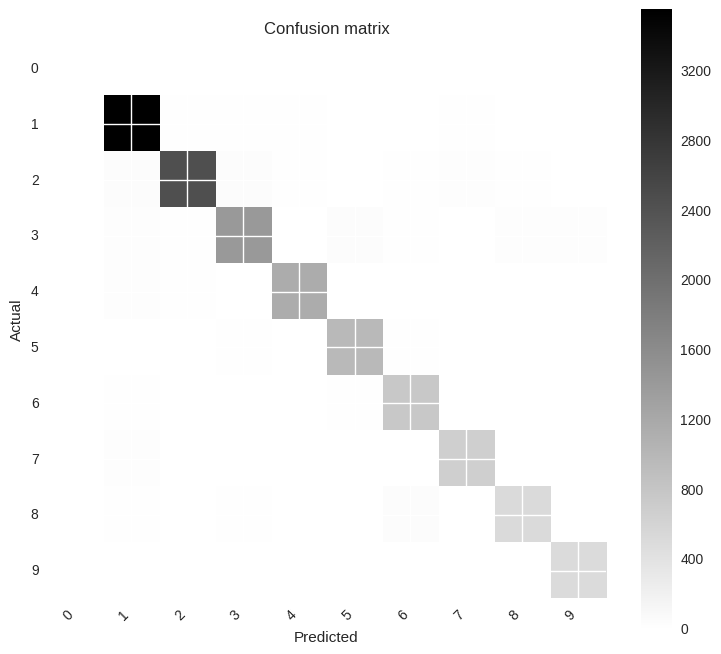

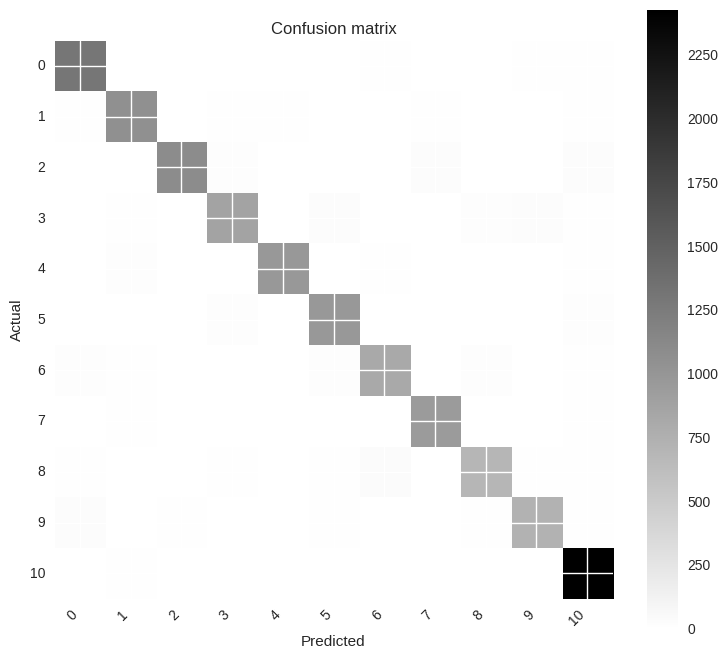

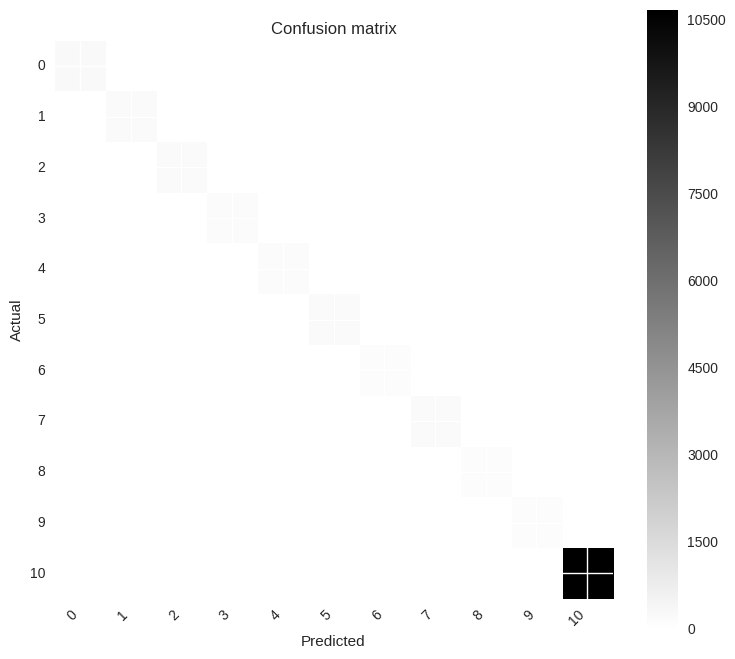

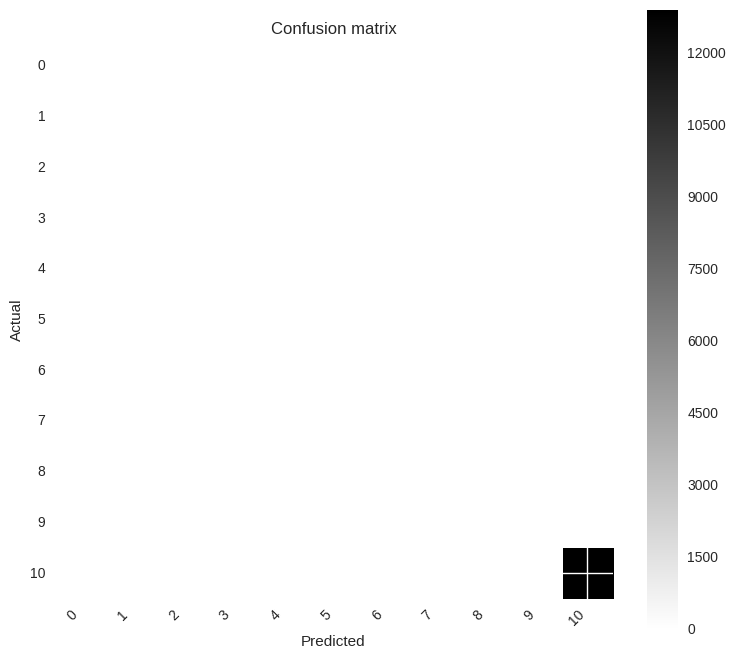

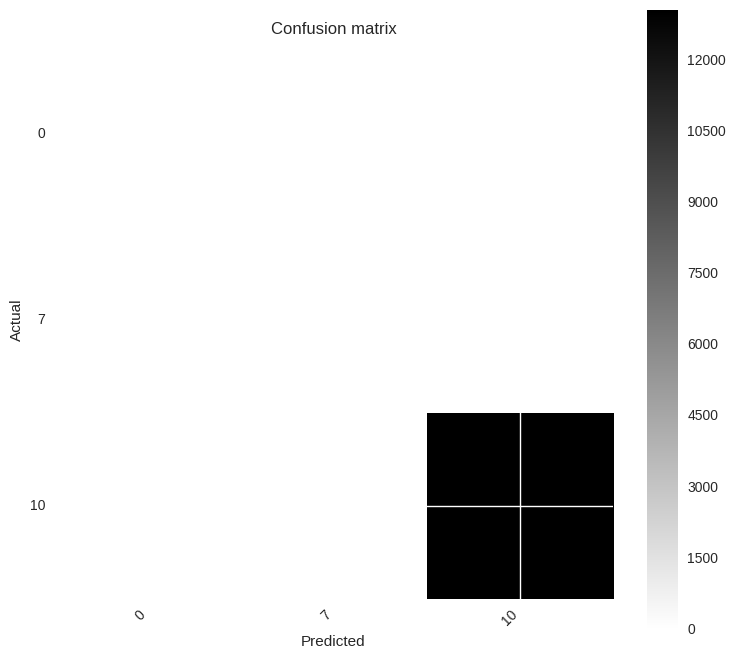

In [6]:
import csv
num_steps = 100001
checkpoint_dir = '/home/ubuntu/save'
train_acc_plot, valid_acc_plot, loss_plot = {}, {}, {}

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    print('Initialized')
    from time import time
    t0 = time()
    
    # Merge all the summaries and write them out to /home/... (Amazon AMI EC2 Instance default dir)
    merged = tf.merge_all_summaries()
    writer = tf.train.SummaryWriter('/home/ubuntu/temp/trial/t001', session.graph)

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions, summary = session.run(
          [optimizer, loss, train_prediction, merged], feed_dict=feed_dict)
        if (step % 1000 == 0):
            
            train_accuracy = accuracy(predictions, batch_labels[:,1:6])
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6]) 
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_accuracy)
            print('Validation accuracy: %.1f%%' % valid_accuracy)
            
            # Store training, validation accuracy and loss data
            train_acc_plot[step] = train_accuracy
            valid_acc_plot[step] = valid_accuracy
            loss_plot[step] = l
            
            # Write training, validation accuracy and loss data to csv file
            with open("sensitivty_0.7.csv", "a") as myfile:
                wrt = csv.writer(myfile, delimiter=',')
                wrt.writerow((step, train_accuracy, valid_accuracy, l))
            
            # Write summaries to TensorBoard
            writer.add_summary(summary, step)
            
            # Saves model checkpoint
            save_path = saver.save(session,'CNN_model_multi_tmp.ckpt',global_step=step)
    
    # Evaluate confusion matrix over each digit sequence slot [N1, N2, N3, N4, N5]
    print("Confusion Matrix")
    print("Slot 1")
    cm1 = conf_mat(test_labels[:,1], (np.argmax(test_prediction.eval(), 2).T[:,0]))
    print("Slot 2")
    cm2 = conf_mat(test_labels[:,2], (np.argmax(test_prediction.eval(), 2).T[:,1]))
    print("Slot 3")
    cm3 = conf_mat(test_labels[:,3], (np.argmax(test_prediction.eval(), 2).T[:,2]))
    print("Slot 4")
    cm4 = conf_mat(test_labels[:,4], (np.argmax(test_prediction.eval(), 2).T[:,3]))
    print("Slot 5")
    cm5 = conf_mat(test_labels[:,5], (np.argmax(test_prediction.eval(), 2).T[:,4]))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    print("Total run time:", round(((time()-t0)/60), 1), "min")
    print("Model saved in file: %s" % save_path)

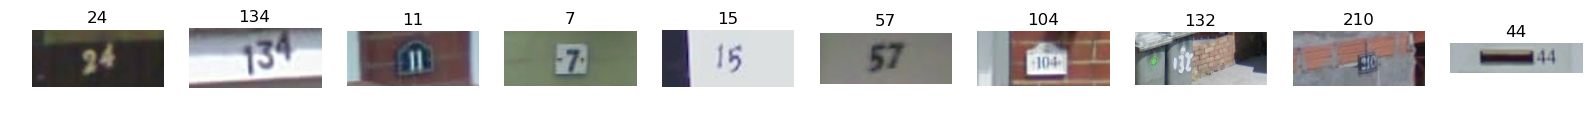

In [4]:
# Load a few test images to feed into model.
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    filepath = os.path.join('test', filename)
    im = Image.open(filepath)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [5]:
# Convolutional Neural Network Architecture

img_size = 32
num_channels = 1
num_labels = 11 # 0 - 9, + blank digits
seq_length = 6

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_test_dataset = tf.placeholder(
        tf.float32, shape=(10, img_size, img_size, num_channels))

    # Helper functions for convolution and pooling
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], 
                              strides=[1, 2, 2, 1], padding='SAME')
        
    def avg_pool_2x2(x):
        return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], 
                              strides=[1, 2, 2, 1], padding='SAME')
    
    def mixed_max_avg_pool_2x2(x, alpha):
        return (alpha * max_pool_2x2(x) + (1 - alpha) * avg_pool_2x2(x))
    
    # Variables.
    W_conv_1 = tf.get_variable("W1", shape=[5, 5, 1, 8], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_1 = tf.Variable(tf.constant(0.0, shape=[8]))
    
    W_conv_2 = tf.get_variable("W2", shape=[5, 5, 8, 16], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_2 = tf.Variable(tf.constant(0.0, shape=[16]))

    W_conv_3 = tf.get_variable("W3", shape=[5, 5, 16, 32], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_3 = tf.Variable(tf.constant(0.0, shape=[32]))

    W_conv_4 = tf.get_variable("W4", shape=[3, 3, 32, 64], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_4 = tf.Variable(tf.constant(0.0, shape=[64]))
    
    W_conv_5 = tf.get_variable("W5", shape=[1, 1, 64, 512], 
                               initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              regularizer=tf.contrib.layers.l2_regularizer(0.0005))
    b_conv_5 = tf.Variable(tf.constant(0.0, shape=[512]))


    W_S1 = tf.get_variable("WS1", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S1 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S2 = tf.get_variable("WS2", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S2 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S3 = tf.get_variable("WS3", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S3 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S4 = tf.get_variable("WS4", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S4 = tf.Variable(tf.constant(0.0, shape=[11]))
    W_S5 = tf.get_variable("WS5", shape=[512, 11], 
                           initializer=tf.contrib.layers.xavier_initializer())
    b_S5 = tf.Variable(tf.constant(0.0, shape=[11]))        
        
    # Model.
    def model(data, keep_prob):
        conv = conv2d(data, W_conv_1)
        hidden = tf.nn.relu(conv + b_conv_1)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
       
        conv = conv2d(sub, W_conv_2)
        hidden = tf.nn.relu(conv + b_conv_2)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
       
        conv = conv2d(sub, W_conv_3)
        hidden = tf.nn.relu(conv + b_conv_3)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
        
        conv = conv2d(sub, W_conv_4)
        hidden = tf.nn.relu(conv + b_conv_4)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
        
        conv = conv2d(sub, W_conv_5)
        hidden = tf.nn.relu(conv + b_conv_5)
        sub = mixed_max_avg_pool_2x2(hidden, 0.5)
        
        drop = tf.nn.dropout(sub, keep_prob)
    
        shape = drop.get_shape().as_list()
        print(shape)
        reshape = tf.reshape(drop, [shape[0], shape[1] * shape[2] * shape[3]])

        S1 = tf.matmul(reshape, W_S1) + b_S1
        S2 = tf.matmul(reshape, W_S2) + b_S2
        S3 = tf.matmul(reshape, W_S3) + b_S3
        S4 = tf.matmul(reshape, W_S4) + b_S4
        S5 = tf.matmul(reshape, W_S5) + b_S5
        return [S1, S2, S3, S4, S5]
  
    # Test computation.  
    keep_prob = 1.0
    [S1, S2, S3, S4, S5] = model(tf_test_dataset, keep_prob)

    # Predictions for test data samples.
    test_prediction = tf.pack([tf.nn.softmax(S1),
                      tf.nn.softmax(S2),
                      tf.nn.softmax(S3),
                      tf.nn.softmax(S4),
                      tf.nn.softmax(S5)])
    
    test_prediction = tf.transpose(tf.argmax(test_prediction, 2))     

[10, 1, 1, 512]


In [6]:
# Restore model and test on new input data.
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, "CNN_model_multi_tmp5.ckpt-99000")
    print("Model restored.")
    print('Initialized')

    feed_dict = {tf_test_dataset : test_dataset[im_samples,:,:,:],}
        
    predictions = session.run(test_prediction, feed_dict=feed_dict)
    
    print(predictions)

Model restored.
Initialized
[[ 2  4 10 10 10]
 [ 1  3  4 10 10]
 [ 1  1 10 10 10]
 [ 7 10 10 10 10]
 [ 1  5 10 10 10]
 [ 5  7 10 10 10]
 [ 1  0  4 10 10]
 [ 1  3  1 10 10]
 [ 2  1  0 10 10]
 [ 4  4 10 10 10]]


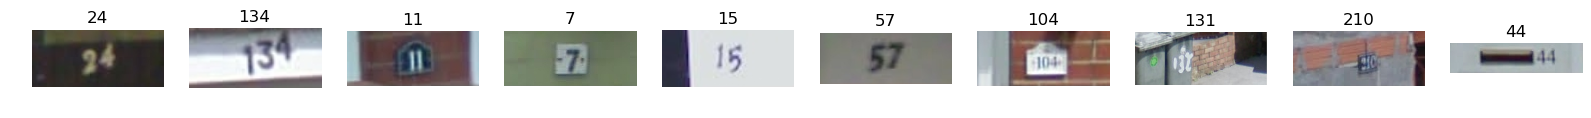

In [8]:
# Show model predictions and compare with images.
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    filepath = os.path.join('test', filename)
    im = Image.open(filepath)
    labels_show = ''
    for k in np.arange(np.sum(predictions[i,:] != 10)):
        labels_show += str(predictions[i,k])

    ax[i].axis('off')
    ax[i].set_title(labels_show, loc='center')
    ax[i].imshow(im)